# 📌 Machine Learning for False Signal Detection in Trading

## 📖 Overview
This project applies **Machine Learning (ML)** to **False Signal Detection** in trading. The goal is to enhance the **win rate** of a trading system by identifying **ineffective trade signals**. By leveraging **supervised learning** with models such as:

- **Decision Tree**
- **Random Forest**
- **Naïve Bayes**

The system learns from **historical trading signals**, **technical indicators**, and their **trade outcomes (profit/loss)** to detect unreliable signals that frequently lead to losses.

---

## 🎯 Objective
- Train ML models to **recognize losing trade patterns**.
- **Filter out false signals** before executing trades.
- Improve overall **trading performance and risk management**.

---

## 📊 Dataset & Features
The dataset consists of **historical trading signals**, **technical indicators**, and **trade outcomes**.

### **🔹 Input Features:**
- **Trading Signals:** Buy/Sell signals generated by the system.
- **Technical Indicators:** Moving Averages, RSI, MACD, Bollinger Bands, etc.
- **Market Data:** Open, High, Low, Close, Volume (OHLCV).
- **Other Derived Indicators:** Volatility, Momentum, Trend Strength, etc.

### **🎯 Target Variable:**
- **Profit/Loss Classification:** Binary output (Win ✅ or Loss ❌)

---

## 🛠️ Machine Learning Models
Three supervised learning models are implemented:

### **🌳 Decision Tree**
- A tree-based model that learns decision rules from historical trades.
- Captures non-linear relationships and interpretable decision paths.

### **🌲 Random Forest**
- An ensemble of Decision Trees to reduce overfitting.
- Improves accuracy and generalization.

### **🧮 Naïve Bayes**
- Probabilistic classifier based on Bayes' Theorem.
- Assumes feature independence and is effective for quick decision-making.

---

## 🔄 Workflow
1. **Data Collection:** Gather trading signals, technical indicators, and trade results.
2. **Data Preprocessing:**
   - Handle missing values.
   - Normalize or standardize features if necessary.
   - Label encode target variable.
3. **Feature Engineering:**
   - Create new indicators or combine existing ones.
   - Identify the most important predictive features.
4. **Model Training & Validation:**
   - Split data into training & testing sets.
   - Train DecisionTree, RandomForest, and NaïveBayes models.
   - Evaluate accuracy, precision, recall, and F1-score.
5. **False Signal Identification:**
   - Detect patterns in losing trades.
   - Develop rules to filter out unreliable trade signals.
6. **Deployment & Integration:**
   - Deploy the model for real-time false signal detection.
   - Integrate with an automated trading system.

---

## 📊 Performance Metrics
- **Accuracy**: Measures the overall correctness of predictions.
- **Precision**: Measures the proportion of correctly identified winning trades.
- **Recall**: Evaluates how many actual winning trades were correctly predicted.
- **F1-Score**: Balances precision and recall.
- **Confusion Matrix**: Visualizes classification performance.

---

## 📌 Expected Outcome
✅ **Reduced False Trades:** Fewer trades based on unreliable signals.  
✅ **Improved Trading Win Rate:** More profitable trades and reduced unnecessary losses.  
✅ **Better Risk Management:** Avoiding bad trades reduces exposure to losses.  

---

## 🚀 Future Enhancements
🔹 Incorporate **Deep Learning (LSTM, CNN)** for pattern recognition.  
🔹 Implement **Reinforcement Learning** for strategy optimization.  
🔹 Experiment with additional **feature selection techniques**.  

---

## 📜 Conclusion
By applying **Machine Learning to trading signals**, this project aims to enhance trading performance by filtering out **false signals**. The insights gained will contribute to **data-driven decision-making** and ultimately **higher profitability** in algorithmic trading.


<br>

<br>

<br>


### Import Libary

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import time
from IPython.display import clear_output

import matplotlib.pyplot as plt
import plotly.graph_objs as go


from sklearn import tree
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, f1_score

import yfinance as yf
import pandas_ta as ta
import vectorbt as vbt

import warnings
warnings.filterwarnings('ignore')

<br>

<br>

### Building Necessary Function

##### Visualizasion Asset Compound Return

In [2]:
def visualizasion_portfolio_compound_return(port,label='',color='#3987b3'):
    port_value = port.value()
    port_compound_return = (port_value  / port_value.iloc[0]) - 1   #Calculate Compound Return of Trading Strategy
    
    index = port_compound_return.index
    value = port_compound_return.values

    # Visualizasion
    plt.figure(figsize=(10, 4))
    plt.plot(index, value*100, label=label,color=color)
    plt.show()

    return index ,value

##### Optimal Decision Tree for False Signal Detection

In [3]:
def find_optimal_tree_gain_profit_signals(X, y, X_train, y_train):
    results = []
    best_clf = None  # To store the best model

    for i in range(3, 50):  # Iterate through different values for `min_samples_leaf`
        clf = tree.DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=i)
        clf = clf.fit(X_train, y_train)

        all_predict = clf.predict(X)
        all_predict = pd.DataFrame(all_predict, columns=['ML_Signals'])

        all_signal_compare = pd.concat([y, all_predict], axis=1)

        more_profit_signal = all_signal_compare[
            (all_signal_compare['ProfitFromSignals'] == -1) & 
            (all_signal_compare['ML_Signals'] == 1)
        ]
        more_loss_signal = all_signal_compare[
            (all_signal_compare['ProfitFromSignals'] == 1) & 
            (all_signal_compare['ML_Signals'] == -1)
        ]

        excess_profit = len(more_profit_signal)
        excess_loss = len(more_loss_signal)
        
        if excess_loss == 0:
            excess_loss = 1  # To avoid division by zero

        excess_profit_loss_ratio = excess_profit / excess_loss

        precision = precision_score(y, all_predict, average='binary')
        f1 = f1_score(y, all_predict, average='binary')

        results.append({
            'min_samples_leaf': i,
            'Precision': precision,
            'F1 Score': f1,
            'ExcessProfit/ExcessLoss': excess_profit_loss_ratio
        })

        # Store the best model
        if best_clf is None or precision > max([r['Precision'] for r in results]):
            best_clf = clf

    results_df = pd.DataFrame(results)

    # Filter rows where ExcessProfit/ExcessLoss > 0
    results_df = results_df[results_df['ExcessProfit/ExcessLoss'] > 0]
    results_df['ExcessProfit/ExcessLoss'] *= -1
    
    # Sort by Precision and F1 Score
    results_df = results_df.sort_values(by=['Precision','ExcessProfit/ExcessLoss','F1 Score'], ascending=False)

    display(optimal_tree_results.head(10))
    print('\n'*5)

    # Plot Decision Tree of the best model
    plt.figure(figsize=(15, 7))
    tree.plot_tree(best_clf, feature_names=X.columns, class_names=['Loss', 'Profit'], filled=True)
    plt.show()

    return results_df

<br>

<br>

### Fetching Data

##### Initail Parameter

In [4]:
symbol = "BTC-USD"
interval = '1h'
periods = '2y'             

##### Fetch Historical Data

In [5]:
data = yf.download(symbol,interval=interval,period=periods)
df = data.copy()
df.columns = df.columns.droplevel(1)
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Datetime,,,,,
2023-03-31 00:00:00+00:00,28265.347656,28306.740234,27932.490234,28032.261719,0
2023-03-31 01:00:00+00:00,28156.681641,28355.330078,28128.500000,28263.376953,293445632
2023-03-31 02:00:00+00:00,28142.048828,28206.248047,28092.935547,28151.294922,0
2023-03-31 03:00:00+00:00,28183.742188,28223.271484,28120.632812,28148.121094,0
2023-03-31 04:00:00+00:00,28189.126953,28200.191406,28105.474609,28173.324219,0
...,...,...,...,...,...
2025-03-30 10:00:00+00:00,83102.578125,83500.781250,83043.320312,83474.351562,0
2025-03-30 11:00:00+00:00,83089.593750,83341.382812,82981.710938,83093.476562,334817280
2025-03-30 12:00:00+00:00,83013.976562,83230.578125,82968.789062,83125.351562,929385472


<br>

<br>

<br>

### Create Technical Indicator

##### Initail Parameter

In [6]:
fast_ma = 10
slow_ma = 30

##### Calculate Indicator

In [7]:
df['fast_ma'] =  ta.ema(close=df['Close'],length= fast_ma)
df['slow_ma'] = ta.ema(close=df['Close'],length= slow_ma)
display(df.tail())

Price,Close,High,Low,Open,Volume,fast_ma,slow_ma
Datetime,,,,,,,
2025-03-30 10:00:00+00:00,83102.578125,83500.781250,83043.320312,83474.351562,0,83107.246089,83203.810556
2025-03-30 11:00:00+00:00,83089.593750,83341.382812,82981.710938,83093.476562,334817280,83104.036573,83196.441729
2025-03-30 12:00:00+00:00,83013.976562,83230.578125,82968.789062,83125.351562,929385472,83087.662026,83184.669783
2025-03-30 13:00:00+00:00,82692.960938,83117.484375,82630.695312,83036.242188,2253066240,83015.898192,83152.946632
2025-03-30 14:00:00+00:00,82730.187500,82832.882812,82620.023438,82662.437500,1524641792,82963.950793,83125.671849


<br>

<br>

<br>

### Backtest Trading Strategy

##### Make Decision Signal

In [8]:
df_signal = pd.DataFrame(index=df.index)
df_signal['Long_Entry'] = df['fast_ma'] > df['slow_ma']
df_signal['Long_Exit'] =  df['fast_ma'] < df['slow_ma']

df_signal.Long_Entry = df_signal.Long_Entry.shift(1).fillna(False)
df_signal.Long_Exit = df_signal.Long_Exit.shift(1).fillna(False)

##### Backtest

In [9]:
port = vbt.Portfolio.from_signals(open=df.Open,
                                  high=df.High,
                                  low=df.Low,
                                  close=df.Close,
                                  entries=df_signal['Long_Entry'], # Buy-Side Entry
                                  exits=df_signal['Long_Exit'],    # Buy-Side Exit
                                  direction='longonly',
                                  init_cash=1000,
                                  fees=0.001
                                 )
original_signal_stats = pd.DataFrame(port.stats(),columns=['Original Signal Stats'])
display(original_signal_stats)

,Original Signal Stats
Start,2023-03-31 00:00:00+00:00
End,2025-03-30 14:00:00+00:00
Period,17450
Start Value,1000.0
End Value,1072.221419
Total Return [%],7.222142
Benchmark Return [%],192.691208
Max Gross Exposure [%],100.0
Total Fees Paid,619.961554
Max Drawdown [%],32.31771


<br>

#### Visualizasion Trading Strategy Compound Return

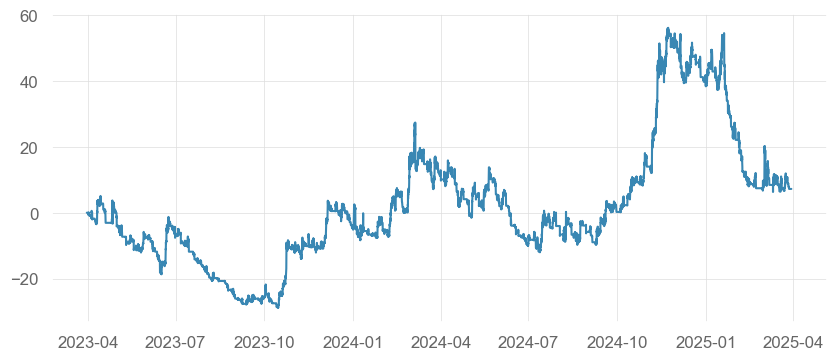

In [10]:
index ,value = visualizasion_portfolio_compound_return(port,label='All signal from Technical Analysis',color='#3987b3')

<br>

<br>

<br>

### Trading Journals 

In [11]:
trades = port.trades.records_readable

# Add 'fast_ma' and 'slow_ma' from the variables
trades['Fast_MA'] = df['fast_ma'].reindex(trades['Entry Timestamp']).values
trades['Slow_MA'] = df['slow_ma'].reindex(trades['Entry Timestamp']).values

trades['Close_pct_change_from_FastMA_Entry'] = trades['Avg Entry Price'] / trades['Fast_MA'] -1
trades['Close_pct_change_from_SlowMA_Entry'] = trades['Avg Entry Price'] / trades['Slow_MA'] -1

trades['Close_pct_change_from_FastMA_Exit'] = trades['Avg Exit Price'] / trades['Fast_MA'] -1
trades['Close_pct_change_from_SlowMA_Exit'] = trades['Avg Exit Price'] / trades['Slow_MA'] -1

# Calculate 'ProfitFromSignals' after the MA columns are added
trades['ProfitFromSignals'] = np.sign(trades['Return'])

# Display the updated trades DataFrame
display(trades.head(5))

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,...,Direction,Status,Position Id,Fast_MA,Slow_MA,Close_pct_change_from_FastMA_Entry,Close_pct_change_from_SlowMA_Entry,Close_pct_change_from_FastMA_Exit,Close_pct_change_from_SlowMA_Exit,ProfitFromSignals
0,0,0,0.035086,2023-04-01 06:00:00+00:00,28472.787109,0.999001,2023-04-02 13:00:00+00:00,28270.775391,0.991913,-9.078731,...,Long,Closed,0,28507.954791,28296.532447,-0.001234,0.006229,-0.008320,-0.000910,-1.0
1,1,0,0.035338,2023-04-03 14:00:00+00:00,28012.880859,0.989931,2023-04-03 15:00:00+00:00,28061.421875,0.991647,-0.266215,...,Long,Closed,1,28112.323367,28122.320344,-0.003537,-0.003892,-0.001811,-0.002165,-1.0
2,2,0,0.035057,2023-04-04 10:00:00+00:00,28229.828125,0.989665,2023-04-05 17:00:00+00:00,28035.638672,0.982858,-8.780307,...,Long,Closed,2,28041.812243,28008.880506,0.006705,0.007888,-0.000220,0.000955,-1.0
3,3,0,0.034876,2023-04-08 06:00:00+00:00,28124.939453,0.980894,2023-04-08 19:00:00+00:00,27932.246094,0.974173,-8.675499,...,Long,Closed,3,28013.678195,27979.680588,0.003972,0.005192,-0.002907,-0.001695,-1.0
4,4,0,0.034664,2023-04-09 02:00:00+00:00,28047.494141,0.972227,2023-04-09 08:00:00+00:00,27895.812500,0.966969,-7.197027,...,Long,Closed,4,28007.426765,27995.479594,0.001431,0.001858,-0.003985,-0.003560,-1.0


<br>

<br>

<br>

### Data Manipulation & Pre-Processing

<br>

#### Assign Entry & Exit Timestamp

In [12]:
entry_ts = trades[['Entry Timestamp']]
exit_ts = trades[['Exit Timestamp']]

<br>

#### Calculate Split Test Set index ( Time Series )
##### To Ensure that Machine Learning Models can test with Actually Unseen Data

In [13]:
pct_split = 70
start_test_position = int(len(trades)*pct_split/100)
print('Percentage :',pct_split,' %')
print('Start Index :',start_test_position)

Percentage : 70  %
Start Index : 216


<br>

<br>

#### Pre-Processing

In [14]:
X = trades[['Close_pct_change_from_FastMA_Entry','Close_pct_change_from_SlowMA_Entry','Close_pct_change_from_FastMA_Exit','Close_pct_change_from_SlowMA_Exit']]
y = trades[['ProfitFromSignals']]

In [15]:
display(X.tail())

,Close_pct_change_from_FastMA_Entry,Close_pct_change_from_SlowMA_Entry,Close_pct_change_from_FastMA_Exit,Close_pct_change_from_SlowMA_Exit
304,0.001548,0.001856,-0.003163,-0.002857
305,0.001551,0.001870,0.029992,0.030321
306,0.001858,0.002126,-0.002884,-0.002616
307,0.000044,0.000323,-0.006296,-0.006019
308,-0.000281,-0.000167,-0.004454,-0.004341


In [16]:
display(y.tail())

,ProfitFromSignals
304,-1.0
305,1.0
306,-1.0
307,-1.0
308,-1.0


<br>


#### Train & Test Split ( As a TimeSeries )

In [17]:
X_train = X.iloc[:start_test_position]
X_test = X.iloc[start_test_position:]
y_train = y.iloc[:start_test_position]
y_test = y.iloc[start_test_position:]

<br>

<br>

<br>

### Find Optimal min_samples_leaf of Decision Tree

In [19]:
# Call the function
optimal_tree_results = find_optimal_tree_gain_profit_signals(X, y, X_train, y_train)

NameError: name 'optimal_tree_results' is not defined

<br>

#### Best min sample for each leaf 

In [ ]:
best_min_simples_leaf = int(optimal_tree_results[['min_samples_leaf']].iloc[0])
print(f'Optimal Precision Score in Training Set is {best_min_simples_leaf} data points for each leaf as a minimum')

<br>

<br>

<br>

<br>

### Model Creation

#### Decision Tree

In [ ]:
dt = tree.DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=best_min_simples_leaf)
dt = dt.fit(X_train, y_train)
dt

#### Random Forest

In [ ]:
rf = RandomForestClassifier( class_weight='balanced',min_samples_leaf=best_min_simples_leaf, n_estimators=100)
rf = rf.fit(X_train,y_train)
rf

#### Naive Bayes

In [ ]:
nb = GaussianNB()
nb = nb.fit(X_train,y_train)
nb

<br>

### Test with only Unseen Data

#### Get Trade Logs

##### Independent Variable

In [ ]:
X_test.index = trades.loc[X_test.index, 'Entry Timestamp']
display(X_test.head())

##### Target Variable

In [ ]:
y_test.index = trades.loc[y_test.index, 'Entry Timestamp']
display(y_test.head())

<br>

##### Filter the dates in the main DataFrame  ( match the dates in the Test Set )

In [ ]:
# Get the index value of the first row in X_test
start_index_value = X_test.index[0]

# Find the position of that index in df
start_index_pos = df.index.get_loc(start_index_value)

# Create a new DataFrame starting from the previous row
df_test = df.iloc[start_index_pos-1:]

# Display the new DataFrame
display(df_test)

<br>

<br>


### Predict the Unseen data

In [ ]:
print('X_Test Index == y_test Index  :',(X_test.index == y_test.index).all(),'\n\n')

# Make predictions
y_pred_dt = dt.predict(X_test)
y_pred_dt = pd.DataFrame(y_pred_dt, columns=["ML_Signal_DT"], index=X_test.index)

y_pred_nb = nb.predict(X_test)
y_pred_nb = pd.DataFrame(y_pred_nb, columns=["ML_Signal_NB"], index=X_test.index)

y_pred_rf = rf.predict(X_test)
y_pred_rf = pd.DataFrame(y_pred_rf, columns=["ML_Signal_RF"], index=X_test.index)

# Combine the results
combined_df = pd.concat([X_test, y_test, y_pred_dt, y_pred_nb, y_pred_rf], axis=1)
display(combined_df)

<br>

<br>

### Reattach the indicators and trading signals to the DataFrame.

In [ ]:
df_test = pd.concat([df_test, combined_df['ML_Signal_DT'],combined_df['ML_Signal_NB'],combined_df['ML_Signal_RF']], axis=1)
display(df_test)

<br>

<br>

### Final Backtest All Trading Strategy ( With Unseen Data / Test Set ) 

<br>

<br>

#### Technical Indicator

In [ ]:
df_signal = pd.DataFrame(index=df_test.index)
df_signal['Long_Entry'] = df_test['fast_ma'] > df_test['slow_ma']
df_signal['Long_Exit'] =  df_test['fast_ma'] < df_test['slow_ma']

df_signal.Long_Entry = df_signal.Long_Entry.shift(1).fillna(False)
df_signal.Long_Exit = df_signal.Long_Exit.shift(1).fillna(False)

In [ ]:
port = vbt.Portfolio.from_signals(open=df_test.Open,
                                  high=df_test.High,
                                  low=df_test.Low,
                                  close=df_test.Close,
                                  entries=df_signal['Long_Entry'], # Buy-Side Entry
                                  exits=df_signal['Long_Exit'],    # Buy-Side Exit
                                  direction='longonly',
                                  init_cash=1000,
                                  fees=0.001
                                 )
original_signal_stats = pd.DataFrame(port.stats(),columns=['Original Signal Stats'])
display(original_signal_stats)

#### Visualizasion Trading Strategy ( with Only Technical Analysis ) Compound Return

In [ ]:
index_ta ,value_ta = visualizasion_portfolio_compound_return(port,label='Original Signal Stats',color='#3987b3')

<br>

<br>


#### Decision Tree 

In [ ]:
dt_signal = pd.DataFrame(index=df_test.index)

dt_signal['Long_Entry'] = (df_test['ML_Signal_DT'] == 1)
dt_signal['Long_Exit'] = (df_test['ML_Signal_DT'] == -1)

dt_signal['Long_Entry'] = dt_signal['Long_Entry'].shift(1).fillna(False) 
dt_signal['Long_Exit'] = dt_signal['Long_Exit'].shift(1).fillna(False)

In [ ]:
# Step 4: ทำ Backtest ด้วย vectorbt โดยใช้สัญญาณ Entry และ Exit ที่ได้
port_dt = vbt.Portfolio.from_signals(
    open=df_test['Open'],  
    high=df_test['High'],
    low=df_test['Low'],
    close=df_test['Close'],
    entries=dt_signal['Long_Entry'],
    exits=dt_signal['Long_Exit'],
    direction='longonly',
    init_cash=1000,
    fees=0.001,
)

dt_portfolio_stats = pd.DataFrame(port_dt.stats(), columns=['DT Portfolio Stats'])
display(dt_portfolio_stats)

#### Visualization of Decision Tree & Trading Strategy (False Signal Detection) Compound Return

In [ ]:
index_dt ,value_dt = visualizasion_portfolio_compound_return(port_dt,label='TA with Decision Tree False Signal Detection', color='#0fec9f')

<br>


#### Naive Bayes

In [ ]:
nb_signal = pd.DataFrame(index=df_test.index)

nb_signal['Long_Entry'] = (df_test['ML_Signal_NB'] == 1)
nb_signal['Long_Exit'] = (df_test['ML_Signal_NB'] == -1)

nb_signal['Long_Entry'] = nb_signal['Long_Entry'].shift(1).fillna(False) 
nb_signal['Long_Exit'] = nb_signal['Long_Exit'].shift(1).fillna(False)

In [ ]:
port_nb = vbt.Portfolio.from_signals(
    open=df_test['Open'], 
    high=df_test['High'],
    low=df_test['Low'],
    close=df_test['Close'],
    entries=nb_signal['Long_Entry'],
    exits=nb_signal['Long_Exit'],
    direction='longonly',
    init_cash=1000,
    fees=0.001
)

nb_portfolio_stats = pd.DataFrame(port_nb.stats(), columns=['NB Portfolio Stats'])
display(nb_portfolio_stats)

#### Visualization of Naive Bayes & Trading Strategy (False Signal Detection) Compound Return

In [ ]:
index_nb ,value_nb = visualizasion_portfolio_compound_return(port_nb,label='TA with NaiveBayes False Signal Detection', color='#8755ea')

<br>

#### Random Forest 

In [ ]:
rf_signal = pd.DataFrame(index=df_test.index)

rf_signal['Long_Entry'] = (df_test['ML_Signal_RF'] == 1)
rf_signal['Long_Exit'] = (df_test['ML_Signal_RF'] == -1)

rf_signal['Long_Entry'] = rf_signal['Long_Entry'].shift(1).fillna(False)  # Shift เพื่อให้สัญญาณเกิดขึ้นหลังจากเกิดสภาวะ
rf_signal['Long_Exit'] = rf_signal['Long_Exit'].shift(1).fillna(False)

In [ ]:
port_rf = vbt.Portfolio.from_signals(
    open=df_test['Open'],
    high=df_test['High'],
    low=df_test['Low'],
    close=df_test['Close'],
    entries=rf_signal['Long_Entry'],
    exits=rf_signal['Long_Exit'],
    direction='longonly',
    init_cash=1000,
    fees=0.001
)

rf_portfolio_stats = pd.DataFrame(port_rf.stats(), columns=['RF Portfolio Stats'])
display(rf_portfolio_stats)

#### Visualization of Random Forest & Trading Strategy (False Signal Detection) Compound Return

In [ ]:
index_rf ,value_rf = visualizasion_portfolio_compound_return(port_rf,label='TA with RandomForest False Signal Detection', color='#39b359')

<br>

#### Visualization of Benchmark Compound Return

In [ ]:
benchmark = df_test[['Close']][:]
benchmark_compound_return = (1+ benchmark.pct_change()).cumprod()-1
(benchmark_compound_return * 100).plot(figsize=(10, 4),color='black',legend=False)
plt.show()

<br>

<br>

<br>

### Performance Evaluation ( Unseen data )

<br>

#### DataFrame

In [ ]:
display(pd.concat([original_signal_stats,dt_portfolio_stats,rf_portfolio_stats,nb_portfolio_stats],axis=1))

<br>

#### Visualization 

In [ ]:
# Plot the compound return over time for both portfolios
plt.figure(figsize=(15, 9))

# Plot Technical Indicator Compound Return 
plt.plot(index_ta, value_ta, label='All signal from Technical Analysis',color='#3987b3')

# Plot the ML Compound Return 
plt.plot(index_dt, value_dt, label='TA with Decision Tree False Signal Detection', color='#0fec9f')

# Plot the ML Compound Return 
plt.plot(index_nb, value_nb, label='TA with NaiveBayes False Signal Detection', color='#8755ea')

# Plot the ML Compound Return 
plt.plot(index_rf, value_rf, label='TA with RandomForest False Signal Detection', color='#39b359')

plt.plot(benchmark_compound_return.index,benchmark_compound_return.values, label='Buy & Hold Benchmark',color='black')

# Add labels and title
plt.title(f'{symbol} Compound Return with Unseen Data (Test Set)')
plt.xlabel('Time')
plt.ylabel('Compound Return ( % )')

# Add a legend to differentiate between the two portfolios
plt.legend()

# Add gridlines 
plt.grid(True)

# Show the plot
plt.show()